In [ ]:
%%capture --no-display

# Librairies utilisées dans compilation_donnees.py
# ! pip install pandas geopandas scipy matplotlib

# Librairies pour les statistiques
# ! pip install sklearn statmodels

# Librairies pour l'importation des données
# ! pip install pandas py7xr xlrd openpyxl

# Librairies et setup pour effectuer le scrapping
# ! pip install pytest-playwright playwright_stealth asyncio
# ! sudo playwright install-deps
# ! playwright install

# 1 - Importation et nettoyage des données

## 1.1 - Données tabulaires

Toutes les fonctions d'extraction de données brutes se trouvent dans le script `scripts/compilation_donnees.py`. Les fonctions `importer_tout()` et `importer_locale(date)` permettent d'importer toutes les sources.

In [1]:
## Importer les données depuis les APIs (plus lent)
# from scripts.importation_donnees_tabuaires import *
# df_SAE, df_SAE_2011, df_dep, df_finess, df_drees, df_pauv = importer_tout() 

## Importer une sauvegarde locale récente des données
from scripts.compilation_donnees import *

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
df_SAE, df_SAE_2011, df_dep, df_finess, df_drees, df_pauv, df_doctolib = importer_locale("2025-12-16-17-35", "2025-11-20-14-56")
df = jointure(df_SAE, df_SAE_2011, df_dep, df_finess, df_drees, df_pauv, df_doctolib)
df_standard = standardisation(df)

In [ ]:
sae = pd.read_excel("https://www.data.gouv.fr/storage/f/2014-01-10T17-34-07/SAE_2011.xls")
sae = sae[['FI', 'RS', 'CATEGORIE', 'DEP', 'nb_ivg', 'nb_ivg_medic','delai_moy_pec_ivg']]

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [16]:
sae = sae[sae['nb_ivg'] != 0]
sae.count()

FI                   573
RS                   573
CATEGORIE            573
DEP                  573
nb_ivg               573
nb_ivg_medic         573
delai_moy_pec_ivg    573
dtype: int64

In [13]:
sae['delai_moy_pec_ivg'].value_counts()

delai_moy_pec_ivg
sans objet    253
7              55
5              40
8              38
6              27
3              27
10             21
4              19
9              19
15             16
2              15
12              8
1               6
11              6
14              6
13              5
16              2
22              2
20              2
27              2
30              1
24              1
28              1
17              1
Name: count, dtype: int64

### 1.1.1 - Sommaire des variables

Les données de la DREES produites concernant les IVG sont indispensables à notre projet. Elles permettent d’avoir l’ensemble des statistiques par département concernant le recours à l’IVG, selon leur type, le praticien qui la réalise et l’âge de la personne y ayant recours. Ces données proviennent de remontées administratives et sont donc exhaustives. En particulier, nous pouvons étudier l'évolution du nombre d'IVG en France (hors DROM).  

<Axes: title={'center': "Évolution nombre total d'IVG en France de 2016 à 2024"}, xlabel='annee'>

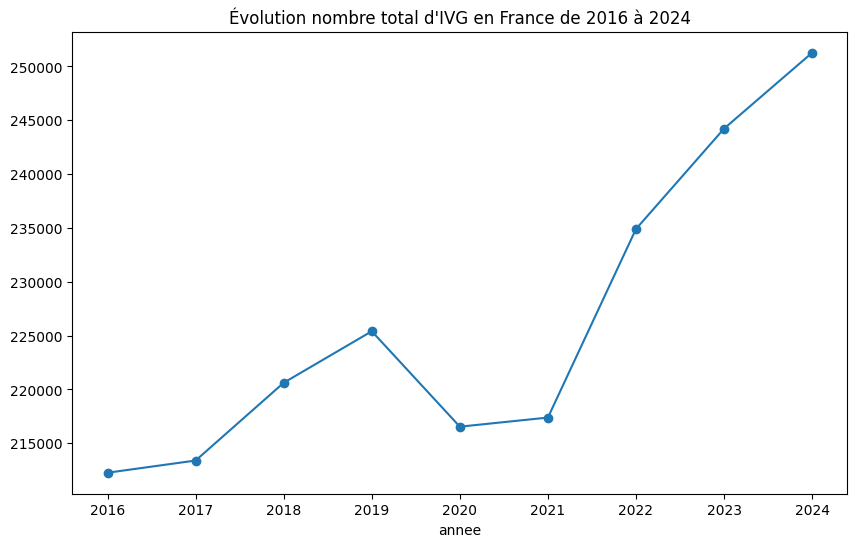

In [ ]:
df_drees_filtre = df_drees[df_drees["département"] == "France entière"];

La hausse du nombre d’IVG depuis 2022 se poursuit, après la nette baisse en 2020 et 2021 en lien avec la pandémie de Covid-19.
Le nombre d’IVG a tendance a augmenté depuis 2017. Cette hausse est interrompu en 2020 et 2021, où le nombre d’IVG connait une chute en lien avec la pandémie de Covid-19. Depuis 2022, ce chiffre augmente de nouveau, et plus rapidement que précédemment. 

In [1]:
ax = df_drees_filtre.plot(x="annee", y=["NB_IVG_TARD", "IVG_HOSP_INS", "IVG_HOSP_MED"], kind="line", marker='o', figsize=(10,6), title="Évolution nombre total d'IVG en France de 2016 à 2024")
ax.legend(["Nombre d'IVG tardive", "Nombre d'IVG instrumentale", "Nombre d'IVG médicamenteuse"], loc="center left",
    bbox_to_anchor=(1, 1))
plt.show()

NameError: name 'df_drees_filtre' is not defined

Le nombre d’IVG tardive suit une évolution similaire. Néanmoins, la hausse est plus faible que celle du nombre d’IVG totale entre 2023 et 2024, ce qui peut indiquer un changement des pratiques, qui suit le changement législatif de 2022. En effet, depuis 2022, il est légal de recourir à une IVG après 14 semaines de grossesse, deux semaines de plus qu’auparavant. Les IVG médicamenteuses sont plus fréquentes que les IVG instrumentales. 

Les données de l’INSEE portant sur les départements ont été nécessaires pour connaître le nombre d’habitants par département, en particulier de femmes en âge de procréer, c'est-à-dire qui ont entre 15 et 49 ans par convention. Il est important de comparer des données d’accessibilité relative et non absolues, car ce nombre varie fortement selon les départements. 

Nous avons utilisés les données de la Statistiques annuelles des établissements (SAE)  produites et publiés par la DREES, afin d’avoir accès aux données par établissement et pas uniquement par région. Cette base nous a permis de connaître le nombre d’établissements de santé réalisant des IVG, et si oui lesquelles (tardives, médicamenteuses, chirurgicales). Ce sont des informations indispensables pour établir l’offre d’infrastructures qui peuvent réaliser des IVG dans chaque département. Ces données proviennent de remontées administratives et sont donc exhaustives.  

Afin de mettre en perspective les données sur les IVG avec des données concernant les caractéristiques socio-démographiques, nous avons utilisé les données produites par l’INSEE sur les taux de pauvreté par département. Le but est de tester un potentiel lien entre le niveau de pauvreté des départements et le recours aux IVG, en considérant les infrastructures présentes sur le territoire. 



| Variable                 | Description                                                                                                      | Source   | Exemple |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------- | -------- | ------- |
| code_dep                 | Code du département                                                                                              | INSEE    |         |
| département              | Nom du département                                                                                               | INSEE    |         |
| femmes                   | Nombre de femmes 15-49 ans                                                                                       | INSEE    |         |
| pris                     | Nombre de prise en charge des interruptions volontaires de grossesse                                             | SAE 2024 |         |
| conv                     | Nombre de conventions avec médecins pour IVG médicamenteuses                                                     | SAE 2024 |         |
| centre_de_sante_sexuelle | Nombre de Centres de santé sexuelle                                                                              | Finess   |         |
| ceGIDD                   | Nombre de Centres gratuit d'information de dépistage et de diagnostic                                            | Finess   |         |
| ivg1214                  | Nombre d'IVG pratiquées les 13ème et 14ème semaine d'aménorrhée (13 et 14 SA)                                    | SAE 2024 |         |
| ivg1516                  | Nombre d'IVG pratiquées les 15ème et 16ème semaine d'aménorrhée (15 et 16 SA)                                    | SAE 2024 |         |
| centres_total            | centre_de_sante_sexuelle + ceGIDD                                                                                |          |         |
| hopitaux_sans_ivg_tard   | Nombre d'IVG en hopital sauf les IVG tardives                                                                    |          |         |
| ivg_hosp_ins             | nombre d'IVG instrumentales en établissement de santé                                                            |          |         |
| ivg_hosp_med             | nombre d'IVG médicamenteuses en établissement de santé                                                           |          |         |
| ivg_hosp_inc             | nombre d'IVG méthode inconnue en établissement de santé                                                          |          |         |
| ivg_cab                  | nombre d'IVG en cabinet libéral (y compris téléconsultations)                                                    |          |         |
| ivg_cen                  | nombre d'IVG en centres de santé ou centres de santé sexuelle (y compris IVG instrumentales en centres de santé) |          |         |
| tot_ivg                  | total IVG réalisées                                                                                              |          |         |
| taux_rec                 | taux de recours (pour 1000 femmes de 15 -49 ans, données insee)                                                  |          |         |
| ivg_inst                 | nombre d'IVG instrumentales en établissement de santé                                                            |          |         |
| part_ivg_tard            | part IVG tardives (12 à 16 SA), en %                                                                             |          |         |
| nb_ivg_tard              | nombre d'IVG tardives (12 à 16 SA)                                                                               |          |         |
| ivg_hors_zone            | Part des IVG réalisées hors du département ou de la région de résidence                                          |          |         |
| ratio_ivg_nais           | ratio IVG/naissances                                                                                             |          |         |
| age_inf_18               | nombre d'IVG concernant des mineures                                                                             |          |         |
| age_18_19                |                                                                                                                  |          |         |
| age_20_24                |                                                                                                                  |          |         |
| age_25_29                |                                                                                                                  |          |         |
| age_30_34                |                                                                                                                  |          |         |
| age_35_39                |                                                                                                                  |          |         |
| age_sup_40               |                                                                                                                  |          |         |
| part_inf_18              |                                                                                                                  |          |         |
| part_18_19               |                                                                                                                  |          |         |
| part_20_24               |                                                                                                                  |          |         |
| part_25_29               |                                                                                                                  |          |         |
| part_30_34               |                                                                                                                  |          |         |
| part_35_39               |                                                                                                                  |          |         |
| part_sup_40              |                                                                                                                  |          |         |
|                          |                                                                                                                  |          |         |


In [ ]:
df_standard

,code_dep,département,femmes,pris,conv,centre_de_sante_sexuelle,cegidd,centres_total,hopitaux_sans_ivg_tard,ivg_hosp_ins,...,doctolib_trimestre,doctolib_mois,doctolib_2sem,part_age_inf_18,part_age_18&19,part_age_20_24,part_age_25_29,part_age_30_34,part_age_35_39,part_age_40&plus
0,01,Ain,289335,1.728101,0.345620,0.345620,0.691240,1.036860,0.691240,129.607548,...,30.414571,26.958370,24.193409,0.025054,0.057734,0.208061,0.218410,0.232026,0.180828,0.069172
1,02,Aisne,207602,2.408455,1.926764,2.408455,1.445073,3.853527,0.000000,150.769260,...,2.890146,2.408455,2.408455,0.045223,0.059356,0.234596,0.227812,0.210288,0.154890,0.062747
2,03,Allier,117763,3.396653,4.245816,2.547489,2.547489,5.094979,0.849163,126.525309,...,7.642468,7.642468,5.944142,0.042339,0.057460,0.245968,0.232863,0.193548,0.162298,0.064516
3,04,Alpes-de-Haute-Provence,59730,3.348401,0.000000,0.000000,0.000000,0.000000,0.000000,184.162063,...,16.742006,15.067805,10.045203,0.023569,0.065657,0.208754,0.223906,0.227273,0.188552,0.060606
4,05,Hautes-Alpes,51076,3.915733,43.073068,3.915733,0.000000,3.915733,0.000000,170.334404,...,21.536534,21.536534,17.620800,0.034545,0.045455,0.176364,0.203636,0.229091,0.189091,0.098182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,Essonne,614879,2.114237,6.505345,1.463703,0.000000,1.463703,0.650534,224.434401,...,5.366910,5.041642,3.740573,0.022208,0.050920,0.210501,0.246669,0.217798,0.175127,0.075508
92,92,Hauts-de-Seine,809206,1.606513,5.561007,1.730091,0.000000,1.730091,0.617890,192.163676,...,15.817975,14.582195,13.469994,0.017669,0.037663,0.203658,0.257440,0.220242,0.175759,0.084470
93,93,Seine-Saint-Denis,846920,1.180749,0.118075,2.361498,0.236150,2.597648,0.000000,288.575072,...,24.087281,22.670382,19.128135,0.022231,0.045871,0.216477,0.238608,0.223619,0.166281,0.071723
94,94,Val-de-Marne,687162,1.309735,7.567357,0.727630,0.000000,0.727630,0.436578,206.210471,...,17.172079,16.589974,14.261557,0.019249,0.046962,0.218976,0.244232,0.214061,0.172969,0.082184


In [ ]:
valeur_min = df["femmes"].min()

print(valeur_min) # 27982 < 100 000 : donc on conserve pr avoir un chiffre interprétable mais pas réaliste pr certains départements

## Web Scrapping - Doctolib

Pour avoir un **indice de la disponibilité des IVGs en France**, nous allons utiliser des données issues du site de prise de rendez-vous médicales le plus utilisé en France, **Doctolib**. Par département et spécialisation IVG, les données extraites sont le nombre de localisations différentes proposant un RDV IVG dans un délai de 14, 30 et 90 jours. Ces données sont accessibles à tous gratuitement en utilisant leur moteur de recherche et des filtres (par [ex](https://www.doctolib.fr/ivg-medicamenteuse/paris?availabilitiesBefore=90&regulationSector%5B%5D=CONTRACTED_1&regulationSector%5B%5D=CONTRACTED_1_WITH_EXTRA&regulationSector%5B%5D=CONTRACTED_1_WITH_OPTAM&regulationSector%5B%5D=CONTRACTED_1_WITH_OPTAM_CO&regulationSector%5B%5D=CONTRACTED_2&regulationSector%5B%5D=CONTRACTED_2_WITH_OPTAM&regulationSector%5B%5D=CONTRACTED_2_WITH_OPTAM_CO&regulationSector%5B%5D=CONTRACTED&regulationSector%5B%5D=CONTRACTED_WITH_EXTRA&regulationSector%5B%5D=ORGANIZATION_CONTRACTED)).

Pour la mise en oeuvre, le script est `scrapper_doctolib.py` qui crée un .csv à l'aboutissement. Le script s'appuie sur la librairie `Playwright` permet de faire du web scrapping sur des sites dynamiques (comme Doctolib qui utilise react et javascript) en utilisant des navigateurs "headless" dans l'arrière plan. Avant de finir sur cette librairie, d'autres options ont été tentées : `BeautifulSoup` (pour adapté au parsing des sites statiques) et `Selenium` (une autre librairie de "headless browsers"). Cependant, `Playwright` a était le plus agile pour la gestion du chargement de la page. De plus, `asyncio` est utilisé pour faire du parallélisme et réduire le temps de scrapping.

> Point législatif
> 
> [Source (CNIL) : ](https://www.cnil.fr/fr/focus-interet-legitime-collecte-par-moissonnage)

Exemple des données obtenues (format dataframe pandas) suite au scraping (environ une demi-heure) :